In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

test_num = 6

fwt_modes = 1
modes = 2
main_panels = 20
fwt_panels = 10
panels = main_panels + fwt_panels

# lets go for B2T2 (so 5 DoF)
p = ma.DynamicModelParameters(modes)

## Create some global parameters
p.c = ma.ModelSymbol(value = 1.8,string = 'c') # chord of wing
p.s = ma.ModelSymbol(value = 12,string = 's_t') # total semi-span of wing

p.m_w = ma.ModelSymbol(value = 0.3,string = 'm_w')
p.m_f = ma.ModelSymbol(value = 0.3,string = 'm_f')


# Inner Wing stiffness Properties
p.K = ma.ModelSymbol(value = 100,string = 'K') # Bending stiffness for the wing

# FWT Properties
p.x_c = ma.ModelSymbol(value = 0.3,string = 'x_c')
p.y_c = ma.ModelSymbol(value = 0.3,string = 'y_c')

p.I_xx = ma.ModelSymbol(value = 0.3,string = 'I_xx') # inertia of FWT (uniform bar)
p.Lambda = ma.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle

# Symbols to translate along inner wing and FWT
p.y = sym.Symbol('y') # FWT y chord
p.x = sym.Symbol('x') # FWT x chord

## Aero Parameters
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v') # The stationary point
p.alpha_r = ma.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = ma.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term 

## Main Wing Specific
p.a_i = ma.ModelSymbol(value = 2*np.pi,string = 'a_i')               # C_L slope of main wing
p.a = ma.ModelMatrix(value =[np.pi*2]*panels,length=panels, string='a') # local C_l

## FWT Specific
p.alpha_1 = ma.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = ma.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

# Factor to change the size of joint values
p.eta = ma.ModelMatrix(value = [1]*modes,length=modes,string='eta')

In [3]:
#define refernce frames
wing_root_frame = ma.HomogenousTransform().Translate(0,0,p.q[0])

fwt_root_frame = wing_root_frame.R_x(p.q[-1])
fwt_flexural_frame = fwt_root_frame.Translate(0,p.y,0)
fwt_com_frame = fwt_root_frame.Translate(p.x_c,p.y_c,0)

In [4]:
#Create Elemnts
M_wing = ele.MassMatrix(p.m_w)
M_fwt = ele.MassMatrix(p.m_f,I_xx = p.I_xx)
M_k = ele.Spring(p.q[0],p.K)

inner_wing_ele = ele.RigidElement.point_mass(wing_root_frame,p.m_w,True)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)

In [5]:
Q = ef.BodyForce(p,fwt_com_frame,simplify=False)

In [6]:
# Create the SYmbolic Model
sm = ma.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele,M_k],Q)

0
1
2


In [7]:
t = me.dynamicsymbols._t
theta = sym.Function('theta')(t)
h = sym.Function('h')(t)
qs = [h,theta]
# list(enumerate(qs))
subs = {**{p.q[i]:item for i,item in enumerate(qs)},**{p.qd[i]:item.diff(t) for i,item in enumerate(qs)}}
subs = {**subs,**{i:j for i,j in zip(p.g_v,p.g_v.value)}}

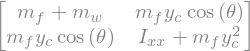

In [8]:
me.msubs(sm.M,subs)

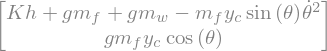

In [9]:
me.msubs(sm.f,subs)

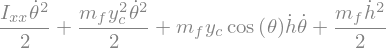

In [10]:
me.msubs(fwt_ele.calc_ke(p),subs)

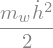

In [11]:
me.msubs(inner_wing_ele.calc_ke(p),subs)

In [12]:
me.msubs(inner_wing_ele.calc_pe(p),subs)

In [13]:
me.msubs(fwt_ele.calc_pe(p),subs)

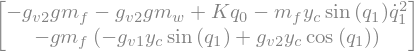

In [14]:
sm.f

In [22]:
sm.ExtForces.Q()

In [15]:
sm.to_matlab_file(p,'C:/Git/fwt_auto/test/')

TypeError: 'Symbol' object is not iterable

In [18]:
sm_lin = sm.linearise(p)
sm_lin.to_matlab_file_linear(p,'C:/Git/fwt_auto/model_2DoF/')

TypeError: object of type 'Symbol' has no len()

In [15]:
sm_lin.ExtForces.Q().jacobian(p.qd).shape